# Geodata Attack - Using GPS

In [1]:
import skmob
from sklearn.cluster import DBSCAN
from skmob.utils import constants
from skmob.utils import utils

from geopy.distance import distance
import pandas as pd
import numpy as np
import csv
import folium

## Preprocessing GPS Data

### Load data from file

In [2]:
gps = 'privamov/privamov-gps.csv'
gsm = 'privamov/privamov-gsm.csv'
december = 'privamov/december-random.csv'
wifi = 'privamov/privamov-wifi.csv'

Loading only a subset of data from `privamov-gps.csv` , by using `MAX_LINES` and `SKIP_LINES`

In [3]:
def formatGPS(file, MAX_LINES = 10**7, SKIP_LINES = 50):
    ids = []
    horodate = []
    lat = []
    long = []
    i = 0
    t = 0
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter='\t', quotechar="'")
        for row in csv_reader:
            if t == SKIP_LINES:
                ids.append(row[0])
                horodate.append(row[1])
                lat.append(row[3])
                long.append(row[2])
                if i > MAX_LINES : 
                    break
                t=0
            else :
                t+=1
            i+=1
        d = { 'ID': ids, 'Horodate':horodate, 'Latitude':lat, 'Longitude':long}  
        df = pd.DataFrame(data=d)
    return df

### Build DataFrame & Quick Visualization

In [4]:
df_gps = formatGPS(december,MAX_LINES=943400, SKIP_LINES=0)
df_gps.head()

,ID,Horodate,Latitude,Longitude
0,1,2014-12-01 04:38:09.288,45.7701433333333,4.86983333333333
1,1,2014-12-01 09:46:33.934,45.7708983333333,4.86651
2,1,2014-12-01 09:46:38.927,45.7708366666667,4.86645666666667
3,1,2014-12-01 09:46:43.95,45.7708383333333,4.86621
4,1,2014-12-01 09:46:49.104,45.7708233333333,4.866125


Aggregating number of points by IDs

In [5]:
def get_unique_id(df):
    ids = df['ID']
    unique_id = set()
    for ident in ids:
        unique_id.add(ident)
    return unique_id  

In [6]:
unique_id = sorted(list(get_unique_id(df_gps)))
print(unique_id)

['1', '11', '13', '14', '15', '16', '17', '19', '2', '20', '21', '22', '23', '24', '25', '44', '5', '6', '7', '8']


In [7]:
agg = df_gps.groupby('ID').size().reset_index(name='counts')
agg.sort_values(by='counts',ascending=False).head()

,ID,counts
0,1,146565
8,2,85367
11,22,69469
6,17,67618
19,8,66955


## Sampling the Data

```
def sample_by_id(file, ident='1'):
    with open(file, 'r') as i, open('subsamples/privamov_gps_id_{}.csv'.format(ident), 'w', newline='') as o:
        r = csv.reader(i, delimiter='\t')
        w = csv.writer(o, delimiter='\t')
        for row in r:
            if row[0] == ident:
                w.writerow(row)
```

```
sample_by_id(gps,'2')
```

### Build SKMOB Object & Visualize trajectories

In [8]:
tdf = skmob.TrajDataFrame(df_gps, latitude='Latitude', longitude='Longitude', datetime='Horodate', user_id='ID')
tdf.head()

,uid,datetime,lat,lng
0,1,2014-12-01 04:38:09.288,45.770143,4.869833
1,1,2014-12-01 09:46:33.934,45.770898,4.866510
2,1,2014-12-01 09:46:38.927,45.770837,4.866457
3,1,2014-12-01 09:46:43.950,45.770838,4.866210
4,1,2014-12-01 09:46:49.104,45.770823,4.866125


In [9]:
print("number of users:\t", len(tdf.uid.unique()))
print("number of records:\t", len(tdf))

number of users:	 20
number of records:	 943402


## Filtering

Filter out all points with speed higher than `max_speed` km/h from the previous point.

In [10]:
from skmob.preprocessing import filtering

In [11]:
ftdf = filtering.filter(tdf, max_speed_kmh=400.)

Very few points have been filtered.

In [12]:
print('Points of the raw trajectory: %s'%len(tdf))
print('Points of the filtered trajectory: %s'%len(ftdf))

Points of the raw trajectory: 943402
Points of the filtered trajectory: 938097


## Compression

Reduce the number of points of the trajectory, preserving the structure.

Merge together all points that are closer than `spatial_radius_km`=0.2 kilometers from each other.

In [13]:
from skmob.preprocessing import compression

In [14]:
ctdf = compression.compress(ftdf, spatial_radius_km=0.2)
ctdf[:4]

,uid,datetime,lat,lng
0,1,2014-12-01 04:38:09.288,45.770143,4.869833
1,1,2014-12-01 09:46:33.934,45.770690,4.865407
2,1,2014-12-01 09:59:13.923,45.760030,4.860470
3,1,2014-12-01 10:04:16.971,45.759023,4.860529


The compressed trajectory has only a small fraction of the points of the filtered trajectory (less than 10%)

In [15]:
print('Points of the filtered trajectory: %s'%len(ftdf))
print('Points of the compressed trajectory: %s'%len(ctdf))

Points of the filtered trajectory: 938097
Points of the compressed trajectory: 11600


## Stop detection

Identify locations where the user spent at least minutes_for_a_stop minutes within a `distance spatial_radius_km` $\times$ `stop_radius_factor`, from a given point.

A new column `leaving_datetime` is added, indicating the time when the user departs from the stop.

In [16]:
from skmob.preprocessing import detection

In [17]:
stdf = detection.stops(ctdf, stop_radius_factor=1, \
            minutes_for_a_stop=30, spatial_radius_km=0.5, 
                       leaving_time=True)
stdf[:4]

,uid,datetime,lat,lng,leaving_datetime
0,1,2014-12-01 04:38:09.288,45.770143,4.869833,2014-12-01 09:46:33.934000
1,1,2014-12-01 10:37:43.944,45.785832,4.879213,2014-12-01 11:29:40.936000
2,1,2014-12-01 11:32:56.936,45.786388,4.879777,2014-12-01 13:35:01.937000
3,1,2014-12-01 13:40:46.003,45.786410,4.879838,2014-12-01 17:20:19.714000


**Visualise the compressed trajectory and the stops**

Click on the stop markers to see a pop up with:

* User ID
* Coordinates of the stop (click to see the location on Google maps)
* Arrival time
* Departure time

In [18]:
map_f = ctdf.plot_trajectory(max_points=1, hex_color=-1, start_end_markers=False)
stdf.plot_stops(map_f=map_f, hex_color=-1)

## Clustering stops

Stops are clustered by spatial proximity using DBSCAN.

The new column cluster is added to the Stops TrajectoryDataFrame, where the value correspond to the cluster ID each stop belong to.

Clusters IDs are integers (0, 1, ...): 0 is the most visited cluster, 1 is the second most visited, ...

In [19]:
from skmob.preprocessing import clustering

In [20]:
cstdf = clustering.cluster(stdf, cluster_radius_km=0.2, min_samples=1)
cstdf

,uid,datetime,lat,lng,leaving_datetime,cluster
0,1,2014-12-01 04:38:09.288,45.770143,4.869833,2014-12-01 09:46:33.934,1
1,1,2014-12-01 10:37:43.944,45.785832,4.879213,2014-12-01 11:29:40.936,0
2,1,2014-12-01 11:32:56.936,45.786388,4.879777,2014-12-01 13:35:01.937,0
3,1,2014-12-01 13:40:46.003,45.786410,4.879838,2014-12-01 17:20:19.714,0
4,1,2014-12-01 17:41:39.286,45.786486,4.879813,2014-12-01 18:43:43.285,0
...,...,...,...,...,...,...
379,8,2014-12-10 18:38:09.016,44.840073,-0.571013,2014-12-10 22:40:31.022,5
380,8,2014-12-10 22:40:31.022,44.841245,-0.573355,2014-12-11 00:08:34.234,4
381,8,2014-12-11 00:08:34.234,44.842047,-0.576130,2014-12-11 09:18:57.351,2
382,8,2014-12-11 09:29:54.361,44.849782,-0.571265,2014-12-11 15:36:56.766,3


In [21]:
import DBSCAN

In [22]:
df = DBSCAN.ST_DBSCAN(stdf)
df

C:\Users\LENOVO\Desktop\OT6\DBSCAN.py:29: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(index, 'cluster', NOISE)
C:\Users\LENOVO\Desktop\OT6\DBSCAN.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(index, 'cluster', cluster_label)# assign a label to core point
C:\Users\LENOVO\Desktop\OT6\DBSCAN.py:36: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(neig_index, 'cluster', cluster_label)
C:\Users\LENOVO\Desktop\OT6\DBSCAN.py:48: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(neig_index, 'cluster', cluster_label)


,uid,datetime,lat,lng,leaving_datetime,cluster
0,1,2014-12-01 04:38:09.288,45.770143,4.869833,2014-12-01 09:46:33.934000,-1
1,1,2014-12-01 10:37:43.944,45.785832,4.879213,2014-12-01 11:29:40.936000,1
2,1,2014-12-01 11:32:56.936,45.786388,4.879777,2014-12-01 13:35:01.937000,1
3,1,2014-12-01 13:40:46.003,45.786410,4.879838,2014-12-01 17:20:19.714000,-1
4,1,2014-12-01 17:41:39.286,45.786486,4.879813,2014-12-01 18:43:43.285000,2
...,...,...,...,...,...,...
379,8,2014-12-10 18:38:09.016,44.840073,-0.571013,2014-12-10 22:40:31.022000,33
380,8,2014-12-10 22:40:31.022,44.841245,-0.573355,2014-12-11 00:08:34.234000,34
381,8,2014-12-11 00:08:34.234,44.842047,-0.576130,2014-12-11 09:18:57.351000,34
382,8,2014-12-11 09:29:54.361,44.849782,-0.571265,2014-12-11 15:36:56.766000,35


In [47]:
locations = df[['lat', 'lng']]
locationlist = locations.values.tolist()

In [48]:
from folium.plugins import MarkerCluster
map2 = folium.Map(location=[45.7, 4.87], zoom_start=6)

marker_cluster = MarkerCluster().add_to(map2)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(marker_cluster)
map2

**Visualise the compressed trajectory and stops: stops in the same clusters have the same color.**

Click on the stop markers to see a pop up with:

* User ID
* Cluster ID
* Coordinates of the stop (click to see the location on Google maps)
* Arrival time
* Departure time

In [23]:
map_f = ctdf[ctdf['uid'] == '1'].plot_trajectory(max_points=1, \
                                               hex_color='#000000', start_end_markers=False)
cstdf[stdf['uid'] == '1'].plot_stops(map_f=map_f)

**Visualise a user's diary**

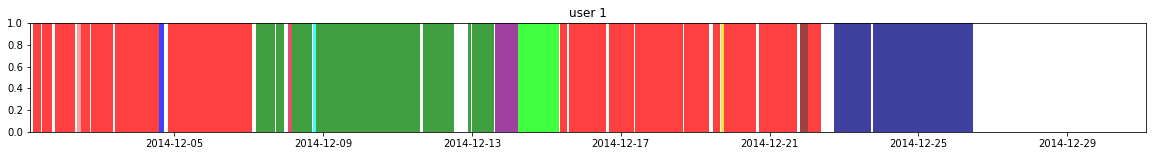

In [46]:
user = '1'
start_datetime = pd.to_datetime('2014-12-01 030000')
end_datetime = pd.to_datetime('2014-12-31 030000')
ax = cstdf.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime)

In [25]:
df_points = cstdf.groupby(['uid', 'cluster']).agg(
    {
         'lat':"mean",    # Sum duration per group
         'lng':"mean"
    }
)
locations = df_points[['lat', 'lng']]
locationlist = locations.values.tolist()

In [26]:
from folium.plugins import MarkerCluster
map2 = folium.Map(location=[38.9, -77.05], zoom_start=6)

marker_cluster = MarkerCluster().add_to(map2)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(marker_cluster)
map2

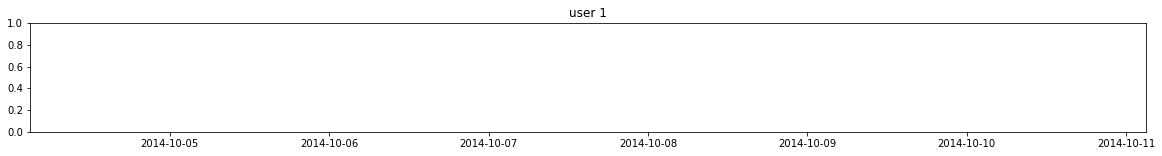

In [27]:
user = '1'
start_datetime = pd.to_datetime('2014-10-04 030000')
end_datetime = pd.to_datetime('2014-10-11 030000')
ax = cstdf.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime)

## Split trajectory into daily trajectories

In [28]:
import skmob
from skmob.utils import utils
from skmob.preprocessing import filtering, compression, detection, clustering

In [29]:
# Re-run all the preprocessing operations in one cell

tdf = skmob.TrajDataFrame(df_gps, latitude='Latitude', longitude='Longitude', datetime='Horodate', user_id='ID') 
ftdf = filtering.filter(tdf, max_speed_kmh=400.)
ctdf = compression.compress(ftdf, spatial_radius_km=0.2)
stdf = detection.stops(ctdf, stop_radius_factor=0.5, \
            minutes_for_a_stop=20.0, spatial_radius_km=0.2, leaving_time=True)
cstdf = clustering.cluster(stdf, cluster_radius_km=0.1, min_samples=1)

In [30]:
cstdf

,uid,datetime,lat,lng,leaving_datetime,cluster
0,1,2014-12-01 04:38:09.288,45.770143,4.869833,2014-12-01 09:46:33.934,1
1,1,2014-12-01 10:40:09.904,45.786385,4.879803,2014-12-01 11:29:40.936,0
2,1,2014-12-01 11:32:56.936,45.786388,4.879777,2014-12-01 13:35:01.937,0
3,1,2014-12-01 13:40:46.003,45.786410,4.879838,2014-12-01 17:20:19.714,0
4,1,2014-12-01 17:20:19.714,46.336378,6.294770,2014-12-01 17:41:39.286,53
...,...,...,...,...,...,...
442,8,2014-12-10 18:38:09.016,44.840073,-0.571013,2014-12-10 22:40:31.022,5
443,8,2014-12-10 22:40:31.022,44.841245,-0.573355,2014-12-11 00:08:34.234,4
444,8,2014-12-11 00:08:34.234,44.842047,-0.576130,2014-12-11 09:18:57.351,2
445,8,2014-12-11 09:29:54.361,44.849782,-0.571265,2014-12-11 15:36:56.766,3


In [31]:
groups = utils.group_df_by_time(cstdf[cstdf['uid'] == '1'], 
                        offset_value=3, offset_unit='hours', add_starting_location=True)
groups[:3]

[  uid                datetime        lat       lng        leaving_datetime  \
 0   1 2014-12-01 04:38:09.288  45.770143  4.869833 2014-12-01 09:46:33.934   
 1   1 2014-12-01 10:40:09.904  45.786385  4.879803 2014-12-01 11:29:40.936   
 2   1 2014-12-01 11:32:56.936  45.786388  4.879777 2014-12-01 13:35:01.937   
 3   1 2014-12-01 13:40:46.003  45.786410  4.879838 2014-12-01 17:20:19.714   
 4   1 2014-12-01 17:20:19.714  46.336378  6.294770 2014-12-01 17:41:39.286   
 5   1 2014-12-01 17:41:39.286  45.786486  4.879813 2014-12-01 18:43:43.285   
 6   1 2014-12-01 19:08:28.290  45.770355  4.870188 2014-12-02 08:01:03.849   
 
    cluster  
 0        1  
 1        0  
 2        0  
 3        0  
 4       53  
 5        0  
 6        1  ,
   uid                datetime        lat       lng        leaving_datetime  \
 0   1 2014-12-01 19:08:28.290  45.770355  4.870188 2014-12-02 08:01:03.849   
 1   1 2014-12-02 08:55:14.322  45.714277  4.917270 2014-12-02 11:41:28.404   
 2   1 2014-12-0

In [32]:
from skmob.measures.individual import home_location

C:\Users\LENOVO\Anaconda3\envs\skmob\lib\site-packages\tqdm-4.41.0-py3.7.egg\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [33]:
hl_df = home_location(tdf)
print(hl_df.head())

100%|██████████| 20/20 [00:00<00:00, 46.22it/s]

  uid        lat        lng
0   1  30.257257 -97.750218
1  11  45.011405  -0.644980
2  13  44.855392  -0.566430
3  14  45.011118  -0.643818
4  15  44.833928  -0.566605


In [34]:
def _work_location_individual(traj, start_day='08:00', end_day='18:00'):
    day_visits = traj.set_index(pd.DatetimeIndex(traj.datetime)).between_time(start_day, end_day)
    if len(day_visits) != 0:
        lat, lng = day_visits.groupby([constants.LATITUDE, constants.LONGITUDE]).count().sort_values(by=constants.DATETIME, ascending=False).iloc[0].name
    else:
        lat, lng = traj.groupby([constants.LATITUDE, constants.LONGITUDE]).count().sort_values(by=constants.DATETIME, ascending=False).iloc[0].name
    work_coords = (lat, lng)
    return work_coords

In [35]:
def work_location(traj, start_day='08:00', end_day='18:00', show_progress=True):
    # if 'uid' column in not present in the TrajDataFrame
    if constants.UID not in traj.columns:
        return pd.DataFrame([_work_location_individual(traj, start_day=start_day, end_day=end_day)], columns=[constants.LATITUDE, constants.LONGITUDE])
    
    if show_progress:
        df = traj.groupby(constants.UID).progress_apply(lambda x: _work_location_individual(x, start_day=start_day, end_day=end_day))
    else:
        df = traj.groupby(constants.UID).apply(lambda x: _work_location_individual(x, start_day=start_day, end_day=end_day))
    return df.apply(pd.Series).reset_index().rename(columns={0: constants.LATITUDE, 1: constants.LONGITUDE})

In [36]:
wl_df = work_location(tdf)
print(wl_df.head())

100%|██████████| 20/20 [00:00<00:00, 34.99it/s]

  uid        lat       lng
0   1  44.515405  4.780835
1  11  45.750283  4.888703
2  13  44.849867 -0.571312
3  14  44.849648 -0.571252
4  15  44.833897 -0.566408


**Visualise the diaries of each sub-trajectory**

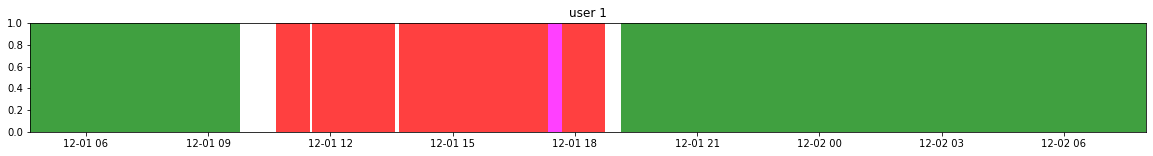

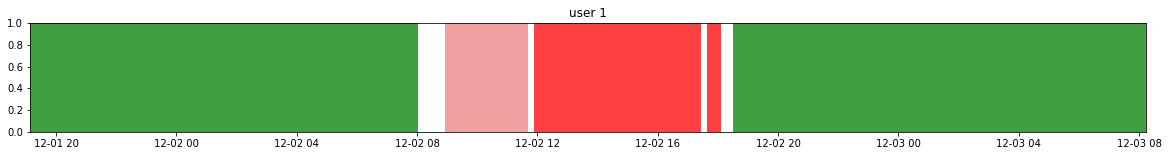

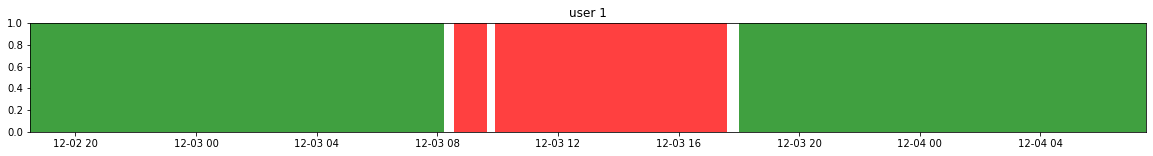

In [37]:
for tdf in groups[:3]:
    user = tdf['uid'].iloc[0]
    ax = tdf.plot_diary(user)

## Routing

Using OSMnx and networkx (taken from https://medium.com/@bobhaffner/osmnx-intro-and-routing-1fd744ba23d8).

In [38]:
import osmnx as ox
import folium

In [39]:
start_i = 0
dt_start = cstdf.iloc[start_i]['leaving_datetime']
dt_end = cstdf.iloc[start_i + 1]['datetime']
user_id = cstdf.iloc[start_i]['uid']

dt_start, dt_end

(Timestamp('2014-12-01 09:46:33.934000'),
 Timestamp('2014-12-01 10:40:09.904000'))

In [40]:
tdf1 = ftdf[(ftdf['datetime'] >= dt_start) & \
            (ftdf['datetime'] <= dt_end) & \
            (ftdf['uid'] == user_id)]
tdf1.plot_trajectory()

## Privacy Risk Assessment

* Simulate privacy attacks and assess risk with a worst-case scenario framework

* First, we import the necessary modules

In [41]:
from skmob.privacy import attacks
from skmob.core.trajectorydataframe import TrajDataFrame
from skmob.utils import constants

In [42]:
# Re-run all the preprocessing operations in one cell
tdf = skmob.TrajDataFrame(df_gps, latitude='Latitude', longitude='Longitude', datetime='Horodate', user_id='ID') 
ftdf = filtering.filter(tdf, max_speed_kmh=300.)
ctdf = compression.compress(ftdf, spatial_radius_km=0.5)
stdf = detection.stops(ctdf, stop_radius_factor=2, \
            minutes_for_a_stop=120.0, spatial_radius_km=1.0, leaving_time=True)
cstdf = clustering.cluster(stdf, cluster_radius_km=1.0, min_samples=1)

In [43]:
cstdf

,uid,datetime,lat,lng,leaving_datetime,cluster
0,1,2014-12-01 04:38:09.288,45.770688,4.865429,2014-12-01 09:59:13.923,0
1,1,2014-12-01 10:34:58.969,45.786374,4.879776,2014-12-01 17:20:19.714,0
2,1,2014-12-01 18:56:03.328,45.772605,4.870203,2014-12-02 08:01:03.849,0
3,1,2014-12-02 08:55:14.322,45.714277,4.917270,2014-12-02 11:41:28.404,10
4,1,2014-12-02 11:41:28.404,45.786644,4.879739,2014-12-02 17:25:59.319,0
...,...,...,...,...,...,...
140,6,2014-12-27 08:43:45.696,48.948472,2.914889,2014-12-28 09:54:24.799,1
141,6,2014-12-28 10:29:47.625,49.071020,2.564377,2014-12-30 08:38:44.148,0
142,7,2014-12-01 02:25:23.013,45.186282,5.748243,2014-12-02 06:41:19.434,0
143,8,2014-12-01 00:18:42.792,45.189155,5.718502,2014-12-01 07:50:47.805,1


In [44]:
at = attacks.LocationAttack(knowledge_length=2)

In [45]:
at.assess_risk(cstdf)

,uid,risk
0,1,1.0
1,11,1.0
2,13,1.0
3,14,1.0
4,15,1.0
5,16,1.0
6,17,1.0
7,19,1.0
8,2,1.0
9,20,1.0
